<a href="https://colab.research.google.com/github/prvshkmr/prvshkmr.github.io/blob/main/Stroke_Predication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stroke Prediction**

In [2]:
# Connecting to drive

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/PRML_Project/'
data_path = folder_path + 'healthcare-dataset-stroke-data.csv'



Mounted at /content/drive


In [3]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.impute import SimpleImputer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

# **K-Nearest Neighbors (KNN)**

In [ ]:
def missing(df):
  missing_number = df.isnull().sum().sort_values(ascending=False)
  missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_values = pd.concat([missing_number,missing_percent],axis=1,keys=['Missing_Number','Missing_Percent'])
  return missing_values

Data Gathering

In [ ]:
df = pd.read_csv(data_path)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Data Preparation

In [ ]:
df.columns = df.columns.str.lower().str.replace('&','_').str.replace(' ','_')
df.columns


Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
df.shape

(5110, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [ ]:
df.describe(include=object).T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


In [ ]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [ ]:
df.duplicated().value_counts()

False    5110
Name: count, dtype: int64

In [ ]:
missing(df)

,Missing_Number,Missing_Percent
bmi,201,0.039335
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
residence_type,0,0.000000
avg_glucose_level,0,0.000000


Data Cleaning

In [ ]:
df.drop('id',axis=1,inplace=True)

In [ ]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

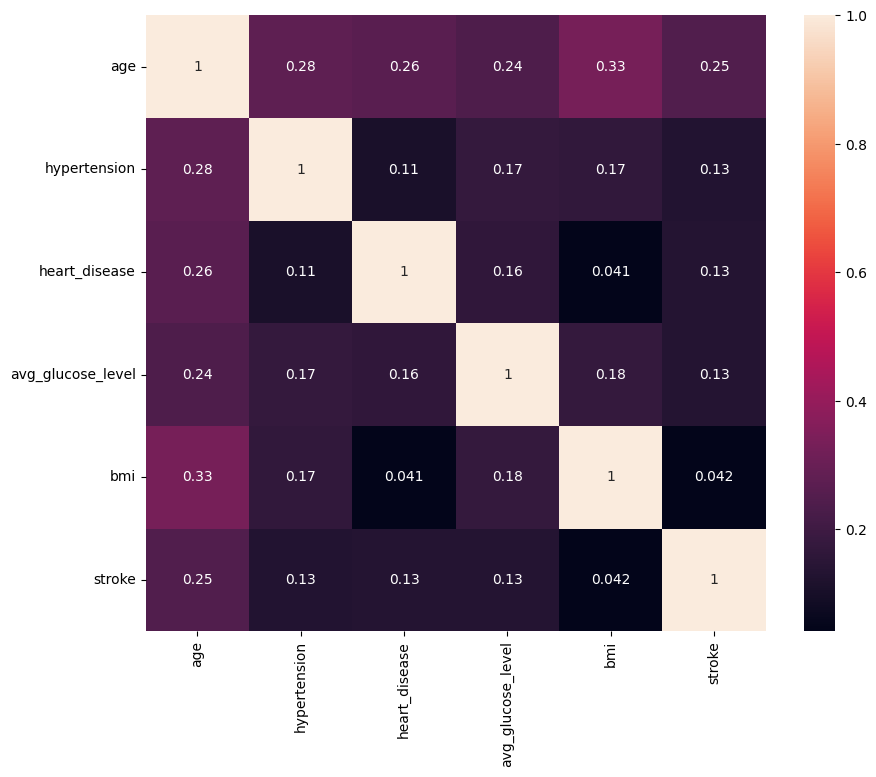

In [ ]:
# One-liner to handle non-numeric data, encode with one-hot, and create the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['float', 'int']).columns

# One-hot encode non-numeric columns, drop remaining non-numeric columns, and create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pd.get_dummies(df, columns=non_numeric_columns).select_dtypes(include=['float', 'int']).corr(), annot=True)
plt.show()



In [ ]:
numerical= df.drop(['stroke'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


Categorical Columns: Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')


In [ ]:
#defiging some subusable functions
def first_looking(col):
  print("column name  :", col)
  print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
  print("num_of_nulls   : ", df[col].isnull().sum())
  print("num_of_uniques : ", df[col].nunique())
  print(df[col].value_counts(dropna = False))

In [ ]:
first_looking("stroke")

column name  : stroke
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
stroke
0    4861
1     249
Name: count, dtype: int64


In [ ]:
df['stroke'].describe()

count    5110.000000
mean        0.048728
std         0.215320
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64

In [ ]:
# Print the skewness of the 'stroke' column
print(f"Skewness: {df['stroke'].skew()}")  # Skewness indicates the asymmetry of the distribution of data in the 'stroke' column

Skewness: 4.193284486071313


<Axes: ylabel='Frequency'>

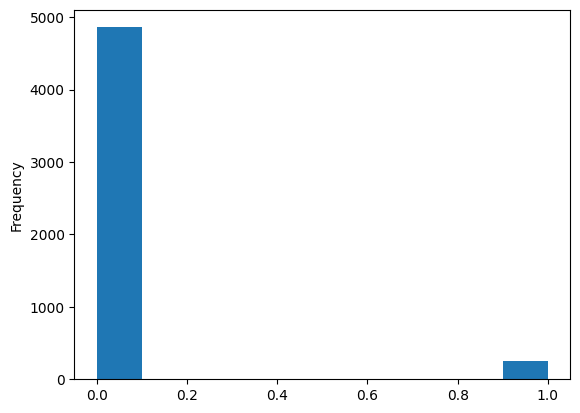

In [ ]:
# Plot a histogram of the 'stroke' column with custom y-axis range
df['stroke'].plot(kind='hist')


In [ ]:
df[numerical].head()

,age,hypertension,heart_disease,avg_glucose_level,bmi
0,67.0,0,1,228.69,36.6
1,61.0,0,0,202.21,NaN
2,80.0,0,1,105.92,32.5
3,49.0,0,0,171.23,34.4
4,79.0,1,0,174.12,24.0


In [ ]:
df[numerical].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237
std,22.612647,0.296607,0.226063,45.283560,7.854067
min,0.080000,0.000000,0.000000,55.120000,10.300000
25%,25.000000,0.000000,0.000000,77.245000,23.500000
50%,45.000000,0.000000,0.000000,91.885000,28.100000
75%,61.000000,0.000000,0.000000,114.090000,33.100000
max,82.000000,1.000000,1.000000,271.740000,97.600000


array([[<Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>]], dtype=object)

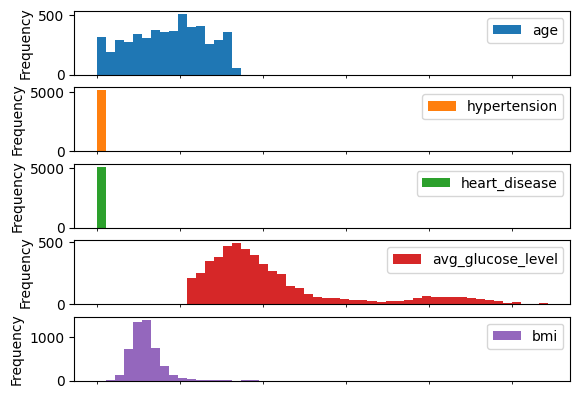

In [ ]:
df[numerical].plot(kind='hist', subplots=True, bins=50, layout=(len(numerical), 1), xticks=[], xlabel='')


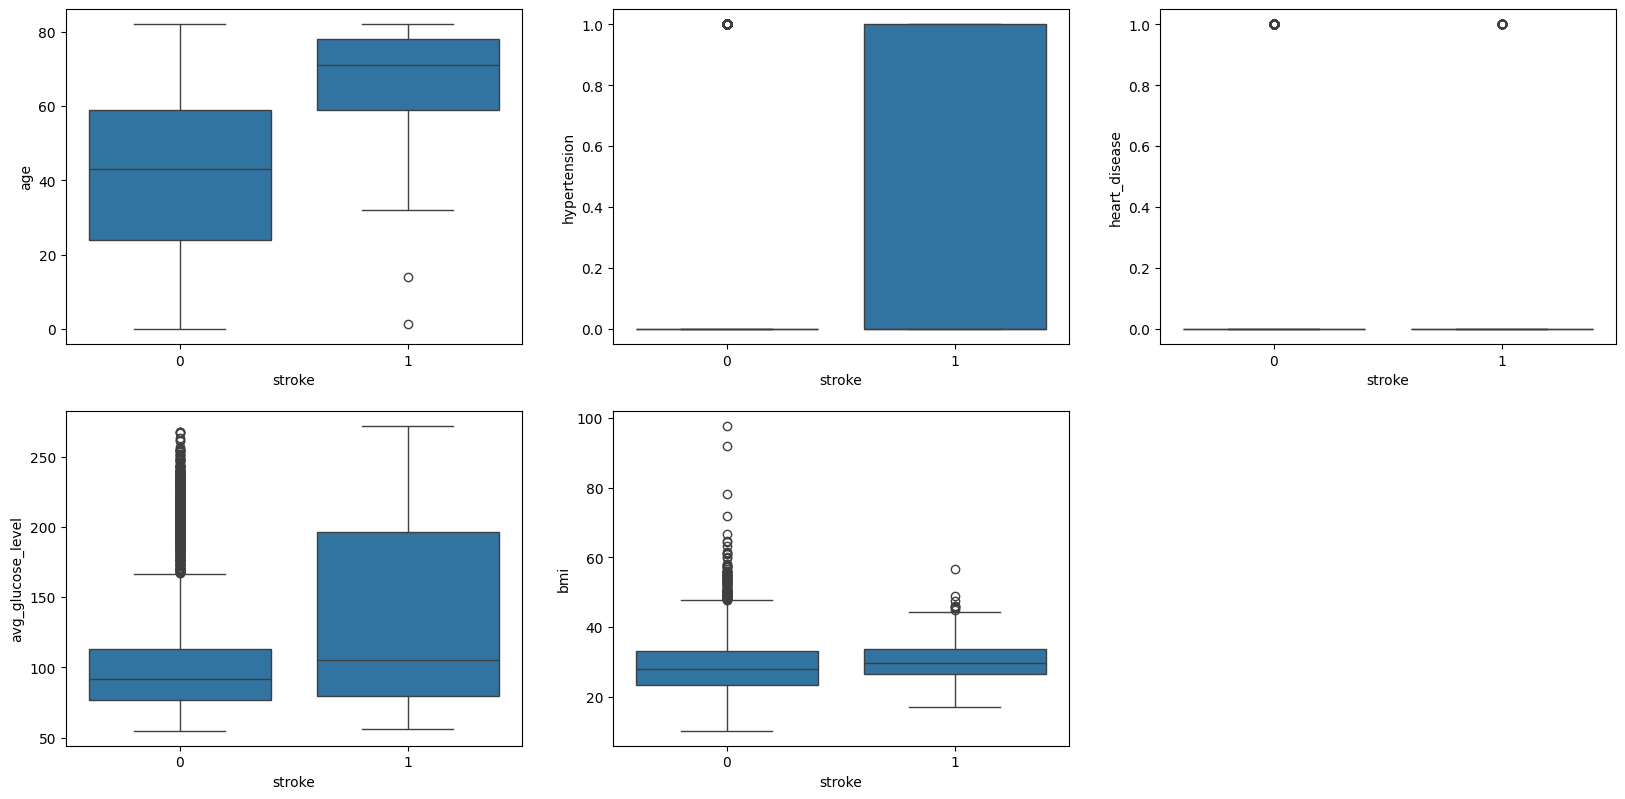

In [ ]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "stroke":
        index += 1
        plt.subplot(4,3,index)
        sns.boxplot(x='stroke',y=feature,data=df)

In [ ]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

heart_disease        3.947244
hypertension         2.715392
avg_glucose_level    1.572284
bmi                  1.055340
dtype: float64

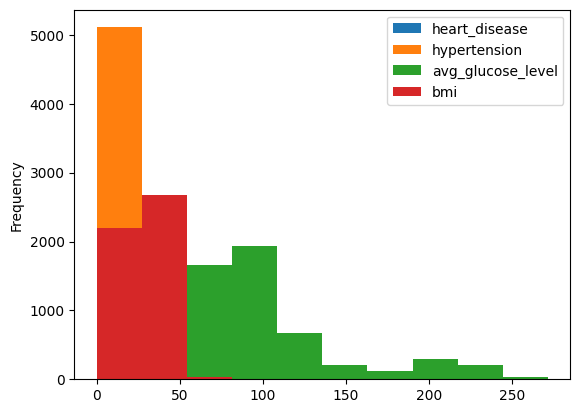

In [ ]:
df[skew_cols.index].plot(kind='hist');

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

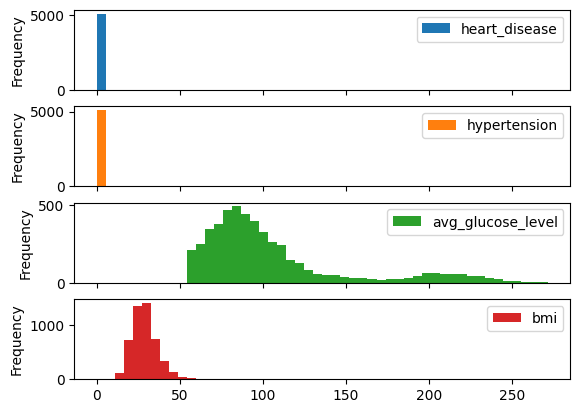

In [ ]:
df[skew_cols.index].plot(kind='hist',subplots=True,bins=50)

In [ ]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols = skew_cols.drop(['heart_disease', 'hypertension'])
skew_cols

avg_glucose_level    1.572284
bmi                  1.055340
dtype: float64

avg_glucose_level    0.889470
bmi                  0.031913
dtype: float64



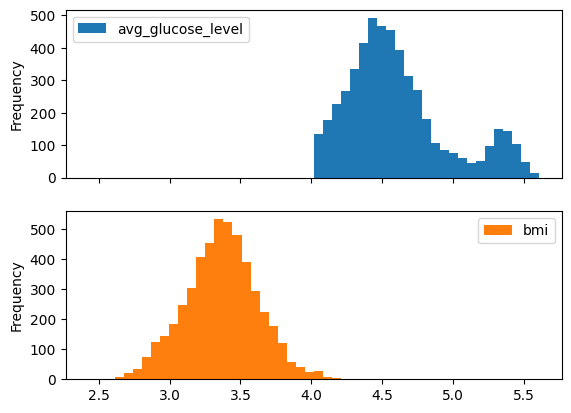

In [ ]:
df_try = df.copy()
df_try = df[skew_cols.index].copy()
for col in skew_cols.index.values:
    df_try[col] = df_try[col].apply(np.log1p)
print(df_try[skew_cols.index].skew())
print()
df_try[skew_cols.index].plot(kind='hist',subplots=True,bins=50);

with power transformer

avg_glucose_level    0.084574
bmi                 -0.000742
dtype: float64



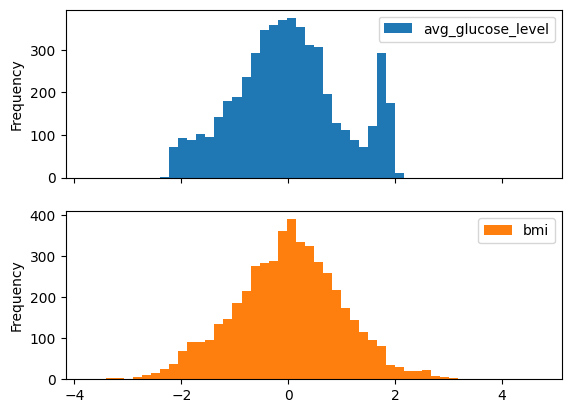

In [ ]:
from sklearn.preprocessing import PowerTransformer

df_trans = df[skew_cols.index].copy()
pt = PowerTransformer(method='yeo-johnson')
trans= pt.fit_transform(df_trans)
df_trans = pd.DataFrame(trans, columns =skew_cols.index )
print(df_trans.skew())
print()
df_trans.plot(kind='hist',subplots=True,bins=50);

In [ ]:
df_trans.columns

Index(['avg_glucose_level', 'bmi'], dtype='object')

In [ ]:
df.shape


(5110, 11)

In [ ]:
df.drop(['avg_glucose_level', 'bmi'], axis=1, inplace=True)

In [ ]:
df.shape

(5110, 9)

In [ ]:
df = pd.concat([df, df_trans], axis=1)

In [ ]:
df.shape

(5110, 11)

In [ ]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'smoking_status', 'stroke',
       'avg_glucose_level', 'bmi'],
      dtype='object')

In [ ]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness.
                  # Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

heart_disease    3.947244
hypertension     2.715392
dtype: float64

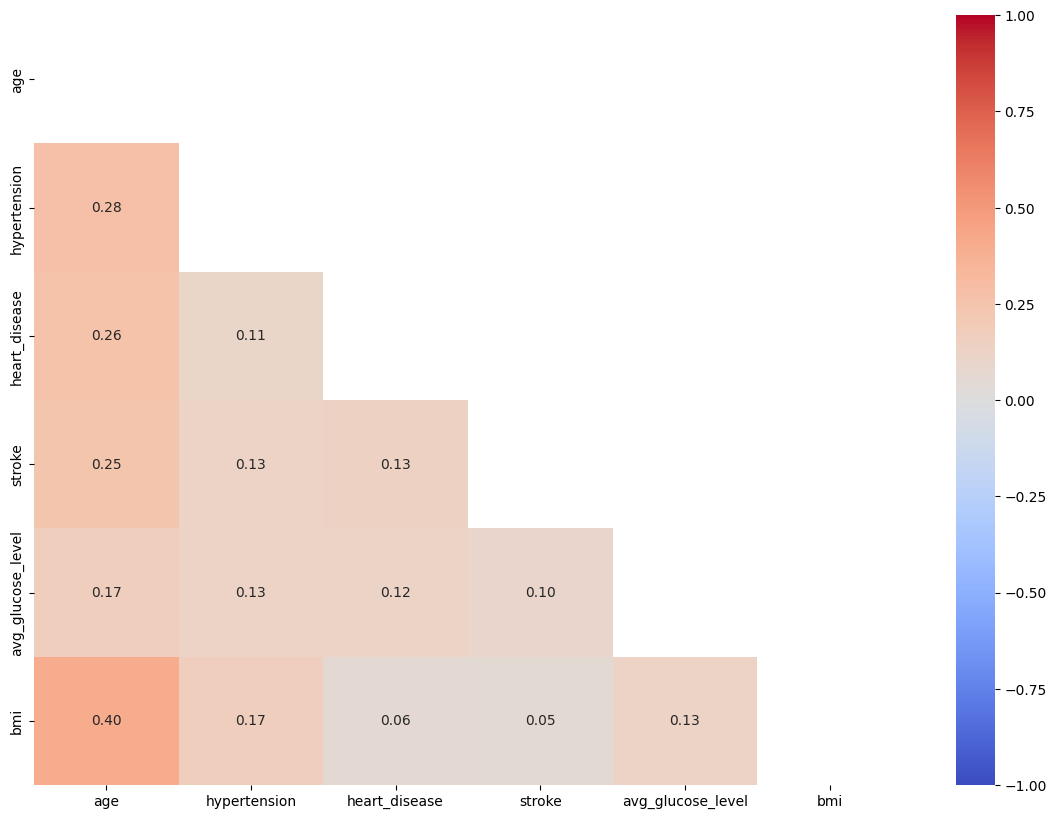

In [ ]:
numerical= df.select_dtypes('number').columns

matrix = np.triu(df[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap (df[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke,avg_glucose_level,bmi
0,Male,67.0,0,1,Yes,Private,Urban,formerly smoked,1,1.862358,1.025698
1,Female,61.0,0,0,Yes,Self-employed,Rural,never smoked,1,1.700414,NaN
2,Male,80.0,0,1,Yes,Private,Rural,never smoked,1,0.394714,0.577383
3,Female,49.0,0,0,Yes,Private,Urban,smokes,1,1.444941,0.791835
4,Female,79.0,1,0,Yes,Self-employed,Rural,never smoked,1,1.472748,-0.567902


In [ ]:
first_looking("age")

column name  : age
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  104
age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: count, Length: 104, dtype: int64


In [ ]:
first_looking("hypertension")

column name  : hypertension
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
hypertension
0    4612
1     498
Name: count, dtype: int64


In [ ]:
first_looking("heart_disease")

column name  : heart_disease
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
heart_disease
0    4834
1     276
Name: count, dtype: int64


In [ ]:
first_looking("avg_glucose_level")

column name  : avg_glucose_level
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3979
avg_glucose_level
 0.035719    6
-0.040362    5
-0.034350    5
-0.374067    5
-0.876760    5
            ..
 0.544268    1
 0.053170    1
 0.091721    1
-1.295508    1
-0.284636    1
Name: count, Length: 3979, dtype: int64


In [ ]:
first_looking("bmi")

column name  : bmi
per_of_nulls   :  % 3.93
num_of_nulls   :  201
num_of_uniques :  418
bmi
 NaN         201
 0.107781     41
 0.068085     38
-0.039865     37
-0.165120     37
            ... 
-3.331840      1
 1.416629      1
 2.481661      1
 4.693087      1
-2.364199      1
Name: count, Length: 419, dtype: int64


Categorical Features

In [ ]:
df[categorical].head().T

,0,1,2,3,4
gender,Male,Female,Male,Female,Female
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
residence_type,Urban,Rural,Rural,Urban,Rural
smoking_status,formerly smoked,never smoked,never smoked,smokes,never smoked


In [ ]:
df[categorical].describe().T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


gender & stroke

In [ ]:
first_looking("gender")

column name  : gender
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


In [ ]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

In [ ]:
df['gender'].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

gender
Female    0.047094
Male      0.051064
Name: stroke, dtype: float64



array([<Axes: ylabel='Frequency'>], dtype=object)

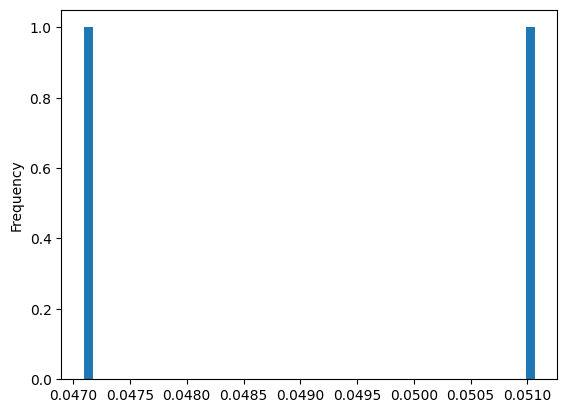

In [ ]:
print(df.groupby('gender')['stroke'].mean().sort_values())
print()
df.groupby('gender')['stroke'].mean().plot(kind='hist',subplots=True,bins=50)

ever_married & stroke

In [ ]:
first_looking("ever_married")

column name  : ever_married
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
ever_married
Yes    3353
No     1756
Name: count, dtype: int64


ever_married
No     0.016515
Yes    0.065613
Name: stroke, dtype: float64



array([<Axes: ylabel='Frequency'>], dtype=object)

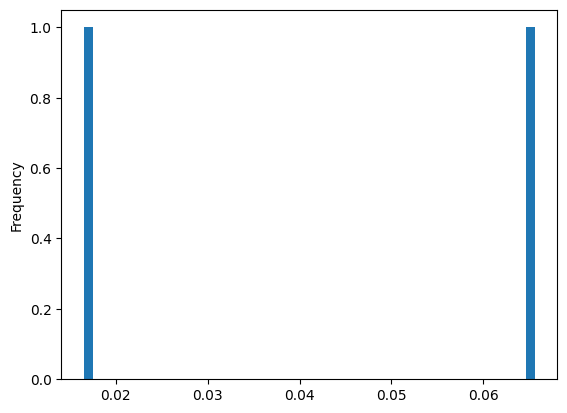

In [ ]:
print(df.groupby('ever_married')['stroke'].mean().sort_values())
print()
df.groupby('ever_married')['stroke'].mean().plot(kind='hist',subplots=True,bins=50)

work_type & stroke

In [ ]:
first_looking("work_type")

column name  : work_type
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5
work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


work_type
Never_worked     0.000000
children         0.002911
Govt_job         0.050228
Private          0.050958
Self-employed    0.079365
Name: stroke, dtype: float64



array([<Axes: ylabel='Frequency'>], dtype=object)

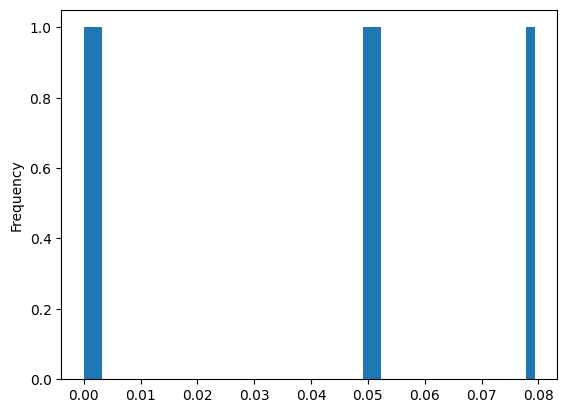

In [ ]:
print(df.groupby('work_type')['stroke'].mean().sort_values())
print()
df.groupby('work_type')['stroke'].mean().plot(kind='hist',subplots=True,bins=50)

residence_type & stroke

In [ ]:
first_looking("residence_type")

column name  : residence_type
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64


residence_type
Rural    0.045364
Urban    0.052003
Name: stroke, dtype: float64



array([<Axes: ylabel='Frequency'>], dtype=object)

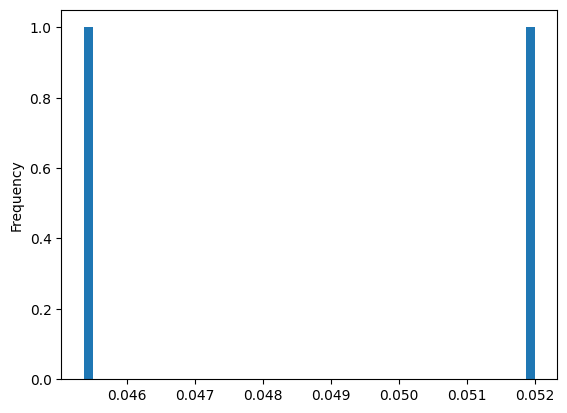

In [ ]:
print(df.groupby('residence_type')['stroke'].mean().sort_values())
print()
df.groupby('residence_type')['stroke'].mean().plot(kind='hist',subplots=True,bins=50)

smoking_status & stroke

In [ ]:
first_looking("smoking_status")

column name  : smoking_status
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


smoking_status
Unknown            0.030440
never smoked       0.047569
smokes             0.053232
formerly smoked    0.079186
Name: stroke, dtype: float64



array([<Axes: ylabel='Frequency'>], dtype=object)

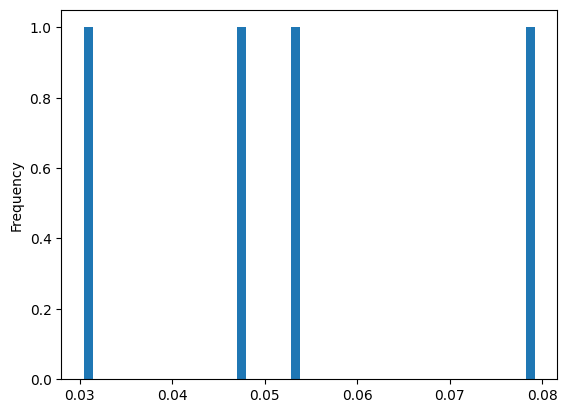

In [ ]:
print(df.groupby('smoking_status')['stroke'].mean().sort_values())
print()
df.groupby('smoking_status')['stroke'].mean().plot(kind='hist',subplots=True,bins=50)

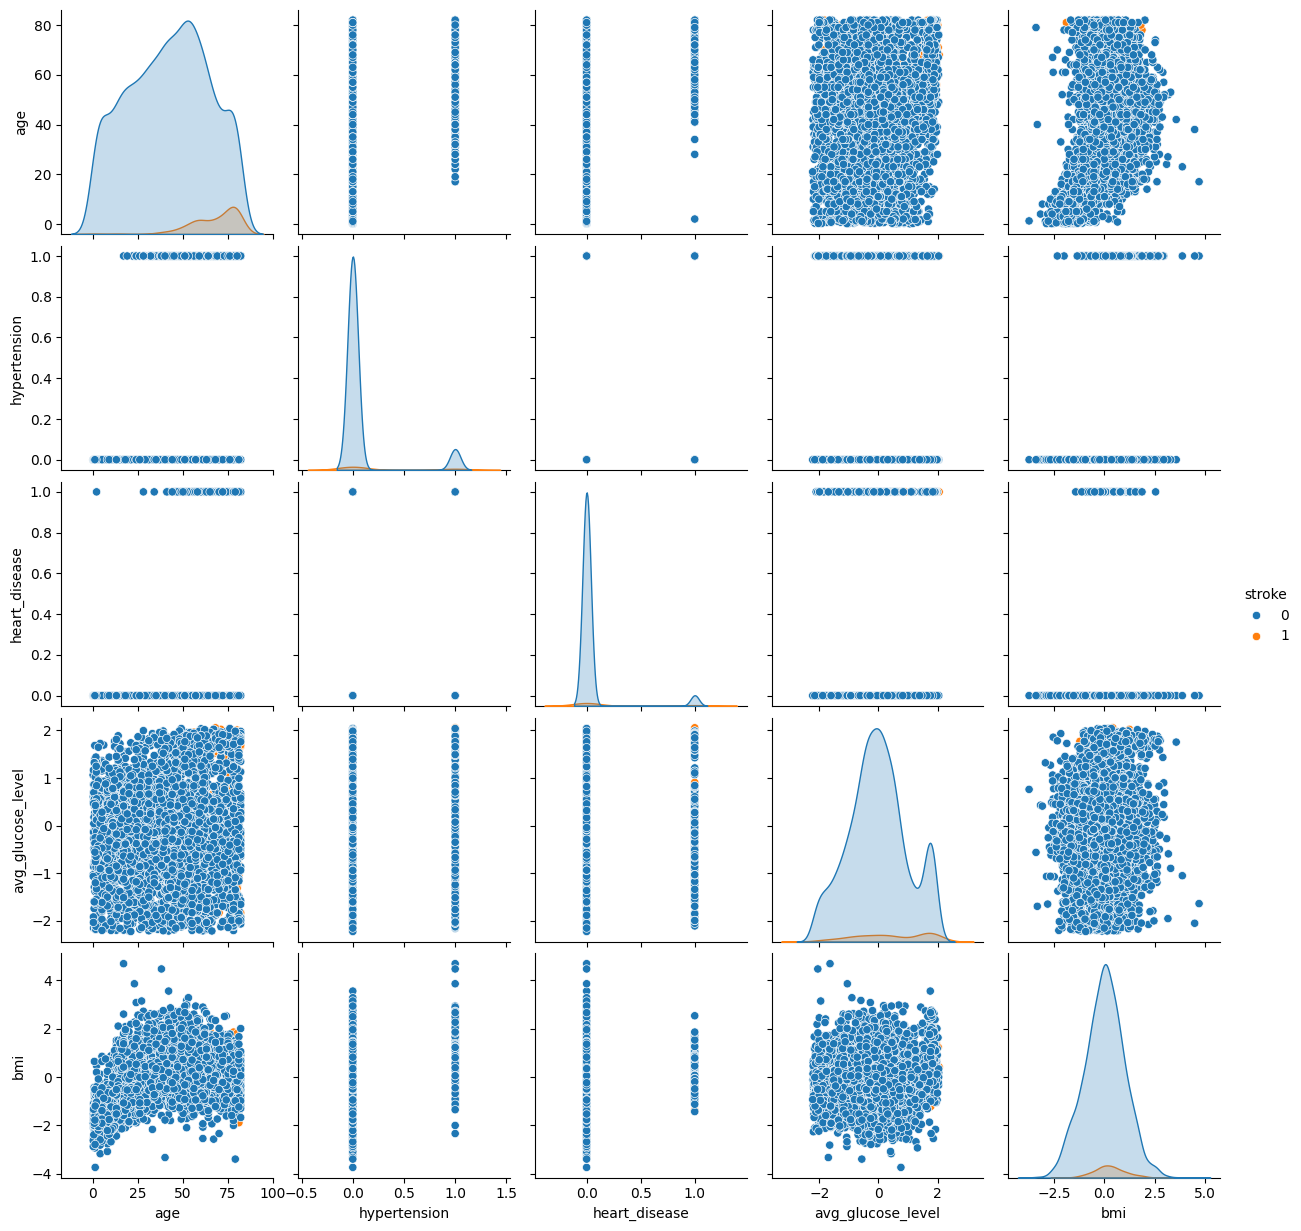

In [ ]:
sns.pairplot(df, hue="stroke");

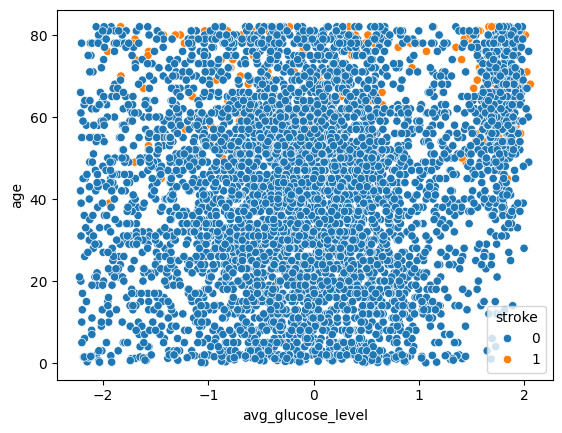

In [ ]:
sns.scatterplot(x = 'avg_glucose_level', y = 'age', hue = 'stroke', data = df);

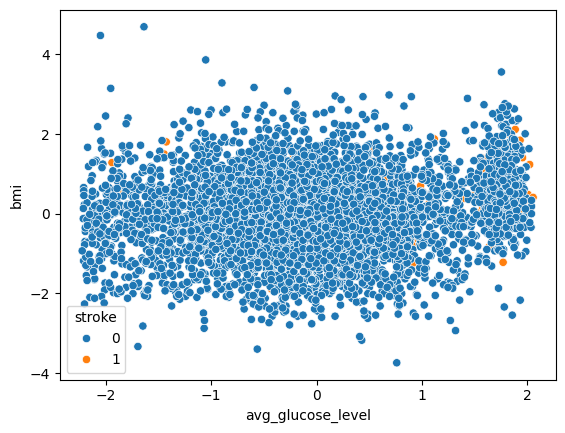

In [ ]:
sns.scatterplot(x = 'avg_glucose_level', y = 'bmi', hue = 'stroke', data = df);

Dummy Operations

In [ ]:
print("Columns before get_dummies():", df.columns)

# Check if the columns are already one-hot encoded
columns_to_encode = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
columns_to_encode = [col for col in columns_to_encode if col in df.columns]

if columns_to_encode:
    df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)
    print("Columns after get_dummies():", df.columns)
else:
    print("No columns to encode.")

Columns before get_dummies(): Index(['age', 'hypertension', 'heart_disease', 'stroke', 'avg_glucose_level',
       'bmi', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')
No columns to encode.


In [ ]:
df.head()

,age,hypertension,heart_disease,stroke,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1.862358,1.025698,True,True,False,True,False,False,True,True,False,False
1,61.0,0,0,1,1.700414,NaN,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,1,0.394714,0.577383,True,True,False,True,False,False,False,False,True,False
3,49.0,0,0,1,1.444941,0.791835,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,1,1.472748,-0.567902,False,True,False,False,True,False,False,False,True,False


<Axes: >

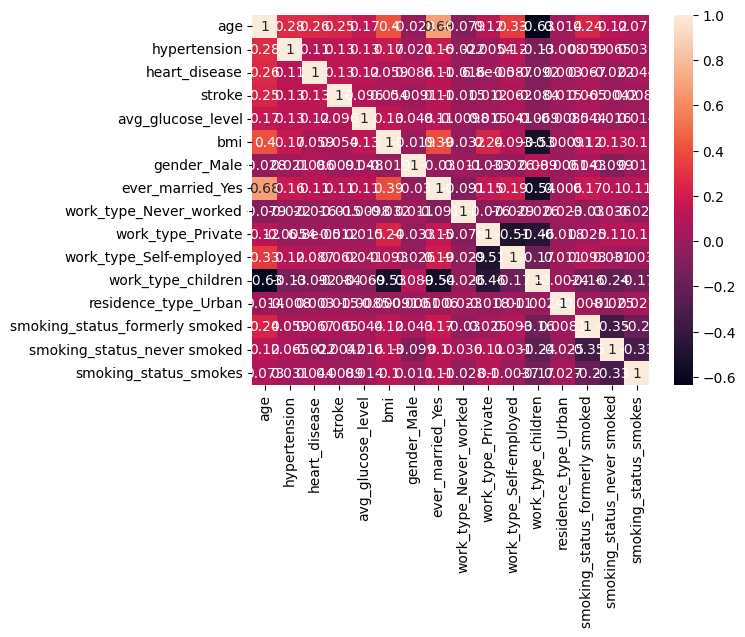

In [ ]:
sns.heatmap(df.corr(), annot=True)

Data Preprocessing

In [ ]:
X = df.drop('stroke',axis=1)
y = df['stroke']

Train / Test and Split

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


Filling the Missing Values

In [ ]:
X_train.bmi.value_counts(dropna=False)

bmi
 NaN         136
-0.039865     32
-0.663541     31
-0.165120     29
-0.444026     27
            ... 
 2.957287      1
 2.624912      1
 2.618216      1
 2.259449      1
 2.222319      1
Name: count, Length: 395, dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

X_train['bmi'] = imputer.fit_transform(X_train['bmi'].values.reshape(-1,1))[:,0]

In [ ]:
X_test['bmi'] = imputer.fit_transform(X_test['bmi'].values.reshape(-1,1))[:,0]

In [ ]:
print(X_train.isnull().sum())

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


In [ ]:
print(X_test.isnull().sum())

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Example usage of MinMaxScaler
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Implement KNN and Evaluate

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [ ]:
knn_pred = knn.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

[[1443    1]
 [  85    4]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.80      0.04      0.09        89

    accuracy                           0.94      1533
   macro avg       0.87      0.52      0.53      1533
weighted avg       0.94      0.94      0.92      1533



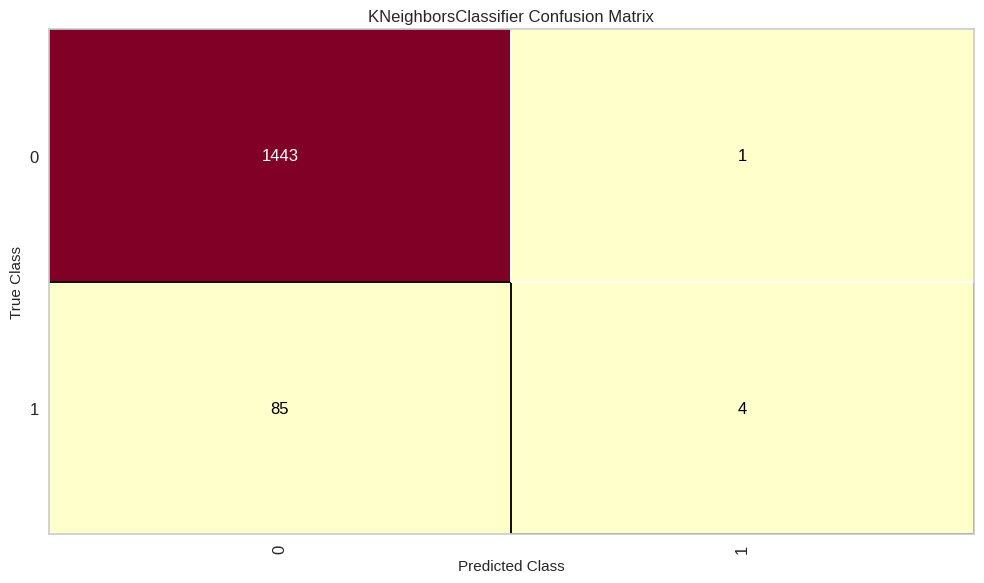

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:

plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(knn)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show()

Elbow Method for Choosing Reasonable K Values

In [ ]:
error_rate = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(1 - recall_score(y_test, pred_i))

Text(0, 0.5, 'Error Rate')

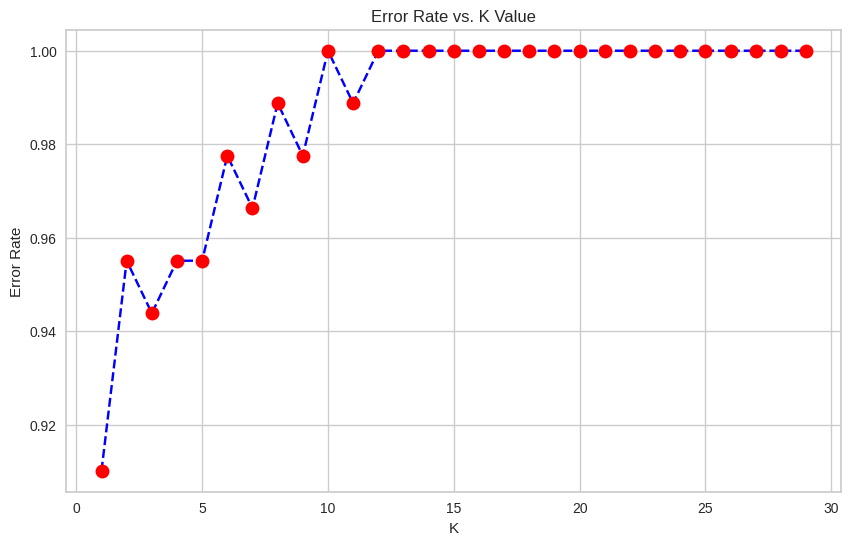

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Scores by Various K Values

In [ ]:
# FIRST A QUICK COMPARISON TO OUR DEFAULT VALUE K=5
knn = KNeighborsClassifier()

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=5')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=5


[[1443    1]
 [  85    4]]


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.80      0.04      0.09        89

    accuracy                           0.94      1533
   macro avg       0.87      0.52      0.53      1533
weighted avg       0.94      0.94      0.92      1533



In [ ]:
# WITH K=1
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=1


[[1383   61]
 [  81    8]]


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1444
           1       0.12      0.09      0.10        89

    accuracy                           0.91      1533
   macro avg       0.53      0.52      0.53      1533
weighted avg       0.90      0.91      0.90      1533



In [ ]:
# WITH K=2
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=2')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=2


[[1436    8]
 [  85    4]]


              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1444
           1       0.33      0.04      0.08        89

    accuracy                           0.94      1533
   macro avg       0.64      0.52      0.52      1533
weighted avg       0.91      0.94      0.92      1533



In [ ]:
# WITH K=3
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=3')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=3


[[1431   13]
 [  84    5]]


              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1444
           1       0.28      0.06      0.09        89

    accuracy                           0.94      1533
   macro avg       0.61      0.52      0.53      1533
weighted avg       0.91      0.94      0.92      1533



In [ ]:
# WITH K=4
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=4')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=4


[[1443    1]
 [  85    4]]


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.80      0.04      0.09        89

    accuracy                           0.94      1533
   macro avg       0.87      0.52      0.53      1533
weighted avg       0.94      0.94      0.92      1533



Cross Validate For Optimal K Value

In [ ]:
model = KNeighborsClassifier(n_neighbors=1)

scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.011800,0.043997,0.916201,0.062500,0.0625,0.062500
2,0.004365,0.024340,0.918994,0.117647,0.1250,0.121212
3,0.004128,0.025353,0.907821,0.000000,0.0000,0.000000
4,0.004196,0.024748,0.916201,0.111111,0.1250,0.117647
5,0.004127,0.024766,0.932961,0.166667,0.1250,0.142857
6,0.004702,0.025557,0.935754,0.111111,0.0625,0.080000
7,0.004232,0.026687,0.927171,0.187500,0.1875,0.187500
8,0.004284,0.026135,0.904762,0.000000,0.0000,0.000000
9,0.004124,0.031898,0.921569,0.125000,0.1250,0.125000
10,0.004517,0.025386,0.938375,0.285714,0.2500,0.266667


In [ ]:
df_scores.mean()[2:]

test_accuracy     0.921981
test_precision    0.116725
test_recall       0.106250
test_f1           0.110338
dtype: float64

Gridsearch Method for Choosing Optimal K Values

In [ ]:
knn_grid = KNeighborsClassifier()

In [ ]:
k_values= range(1,30)

In [ ]:
param_grid = {"n_neighbors":k_values, "p": [1,2], "weights": ['uniform', "distance"]}

In [ ]:
knn_grid_model = GridSearchCV(knn_grid, param_grid, cv=10, scoring= 'recall')

In [ ]:
knn_grid_model.fit(X_train_scaled, y_train)




GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [ ]:
knn_grid_model.best_params_

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

In [ ]:
# NOW WITH K=1
knn = KNeighborsClassifier(n_neighbors=1, p=2, weights='uniform')

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=1


[[1383   61]
 [  81    8]]


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1444
           1       0.12      0.09      0.10        89

    accuracy                           0.91      1533
   macro avg       0.53      0.52      0.53      1533
weighted avg       0.90      0.91      0.90      1533



# **Support Vector Machines (SVM)**

In [5]:
sns.set_style('whitegrid')

Load Data

In [12]:
df_w = pd.read_csv(data_path)
df = df_w.drop('id',axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Data Cleaning

In [13]:
# Replacing missing NA values in 'bmi' with their mean bmi of their gender

F_missing_bmi_index = df[(df.gender == 'Female') & (df.bmi.isna())].index
df.loc[F_missing_bmi_index, 'bmi'] = 29

M_missing_bmi_index = df[(df.gender == 'Male') & (df.bmi.isna())].index
df.loc[M_missing_bmi_index, 'bmi'] = 28

In [14]:
# Removing the one instance where gender is 'Other'

other_index = df[df['gender'] =='Other'].index
df = df.drop(other_index)

Visualizing features

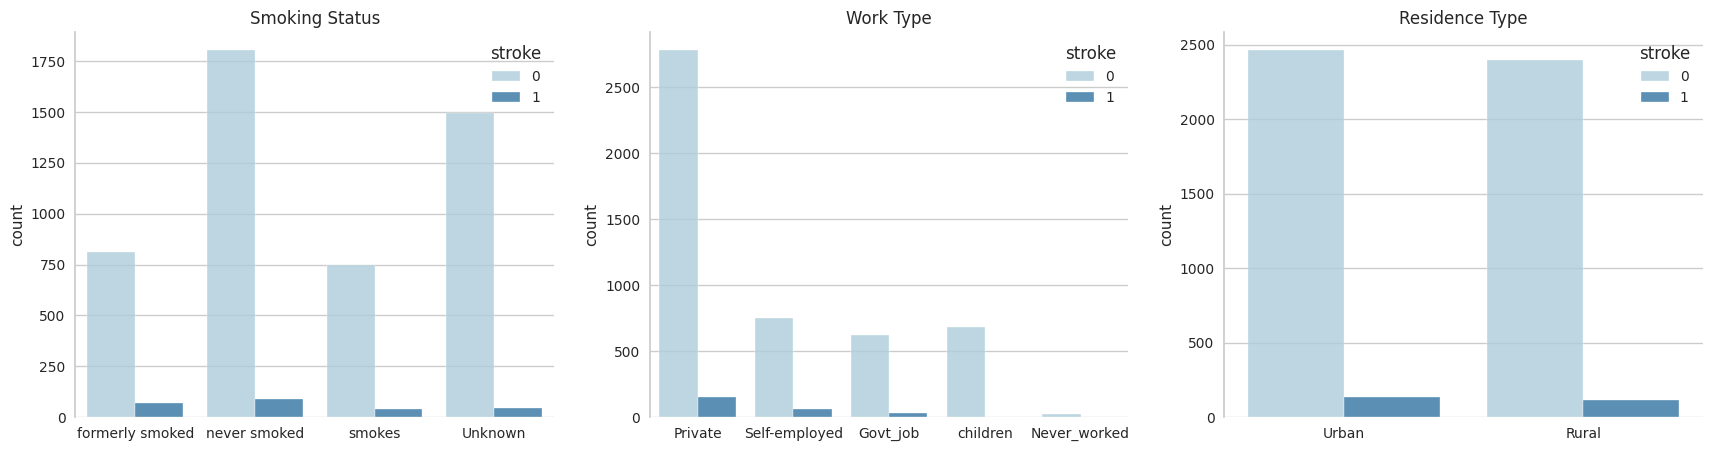

In [18]:

import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(21,5))

plt.subplot(1,3,1)
sns.countplot(x=df['smoking_status'], alpha=0.8, palette="Paired",hue=df['stroke']);
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False);
plt.xlabel('');
plt.title('Smoking Status');

plt.subplot(1,3,2)
sns.countplot(x=df['work_type'], alpha=0.8, palette="Paired", hue=df['stroke']);
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False);
plt.xlabel('');
plt.title('Work Type');

plt.subplot(1,3,3)
sns.countplot(x=df['Residence_type'], alpha=0.8, palette="Paired", hue=df['stroke']);
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False);
plt.xlabel('');
plt.title('Residence Type');

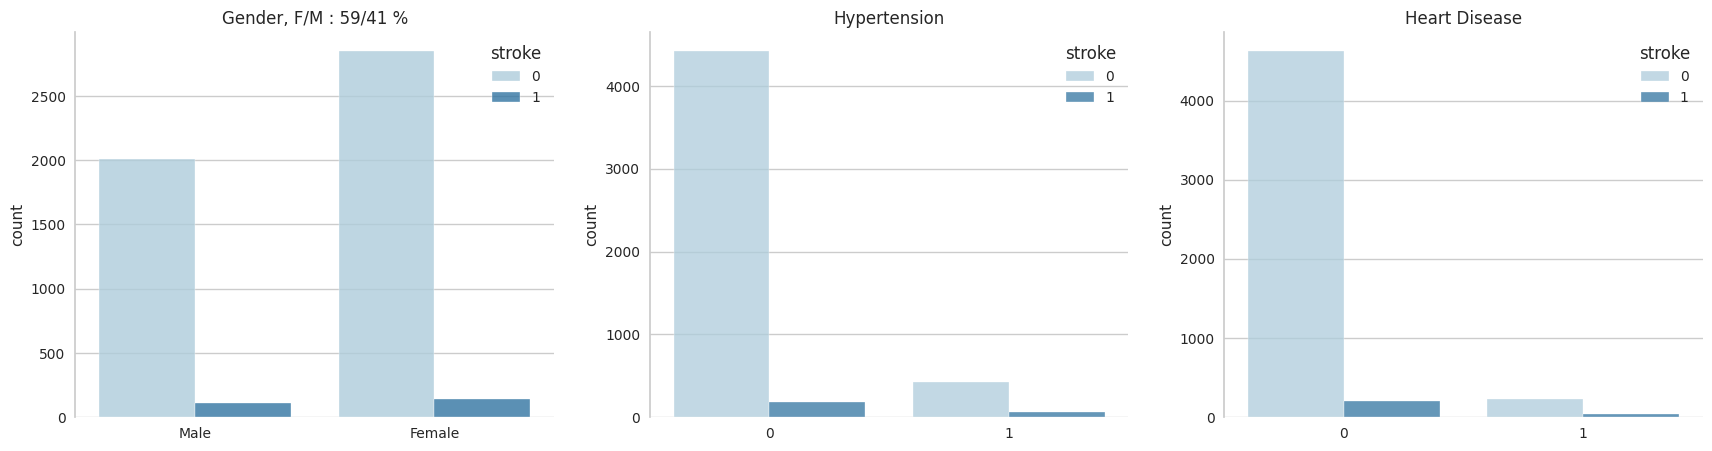

In [19]:

import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(21,5))

plt.subplot(1,3,1)
sns.countplot(x=df['gender'], alpha=0.8, palette="Paired", hue=df['stroke']);
plt.tick_params(axis='both', which='both', bottom=False, left=True, right=False, top=False, labelbottom=True, labelleft=True);
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False);
plt.xlabel('')
plt.title('Gender, F/M : 59/41 %');

plt.subplot(1,3,2)
sns.countplot(x=df['hypertension'], alpha=0.75, palette="Paired", hue=df['stroke']);
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False);
plt.xlabel('');
plt.title('Hypertension');

plt.subplot(1,3,3)
sns.countplot(x=df['heart_disease'], alpha=0.75, palette="Paired", hue=df['stroke']);
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False);
plt.xlabel('');
plt.title('Heart Disease');

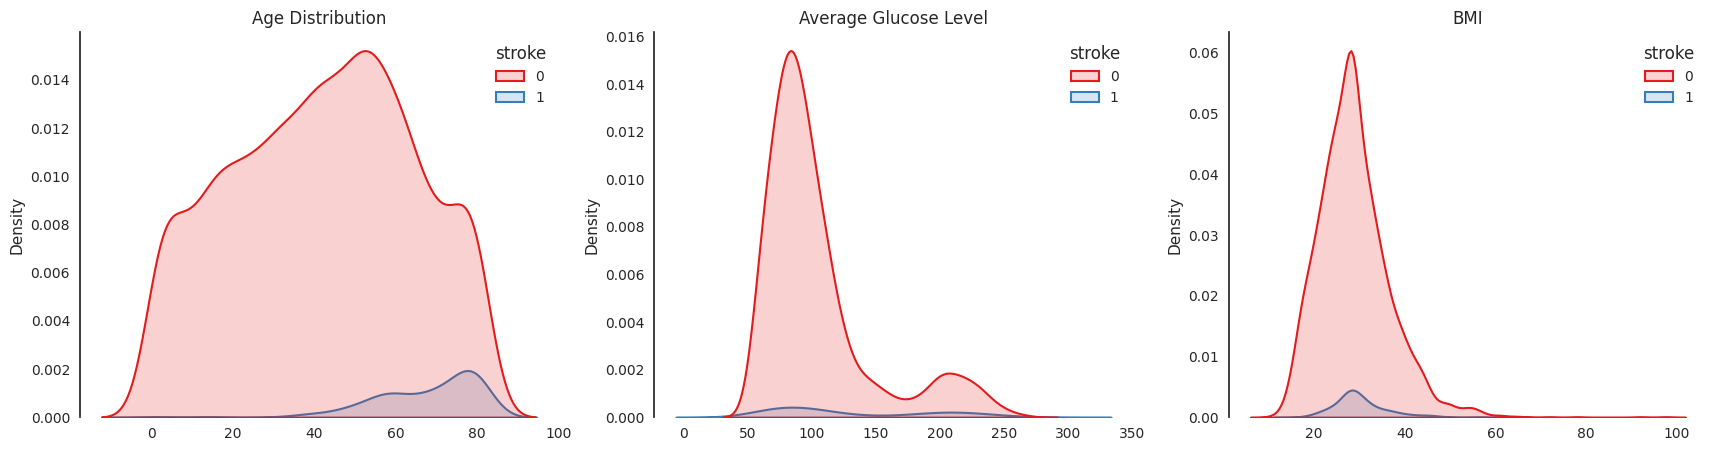

In [20]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('white')
plt.figure(figsize=(21,5))

plt.subplot(1,3,1)
sns.kdeplot(x=df['age'], alpha=0.2, palette="Set1", label='Smoker', fill=True, linewidth=1.5, hue=df['stroke']);
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.xlabel('');
plt.title('Age Distribution');

plt.subplot(1,3,2)
sns.kdeplot(x=df['avg_glucose_level'], alpha=0.2, palette="Set1", label='avg_glucose_level',linewidth=1.5, fill=True, hue=df['stroke']);
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.xlabel('');
plt.title('Average Glucose Level');

plt.subplot(1,3,3)
sns.kdeplot(x=df['bmi'], alpha=0.2, palette="Set1", label='BMI',shade=True, linewidth=1.5, fill=True, hue=df['stroke']);
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False);
plt.xlabel('');
plt.title('BMI');

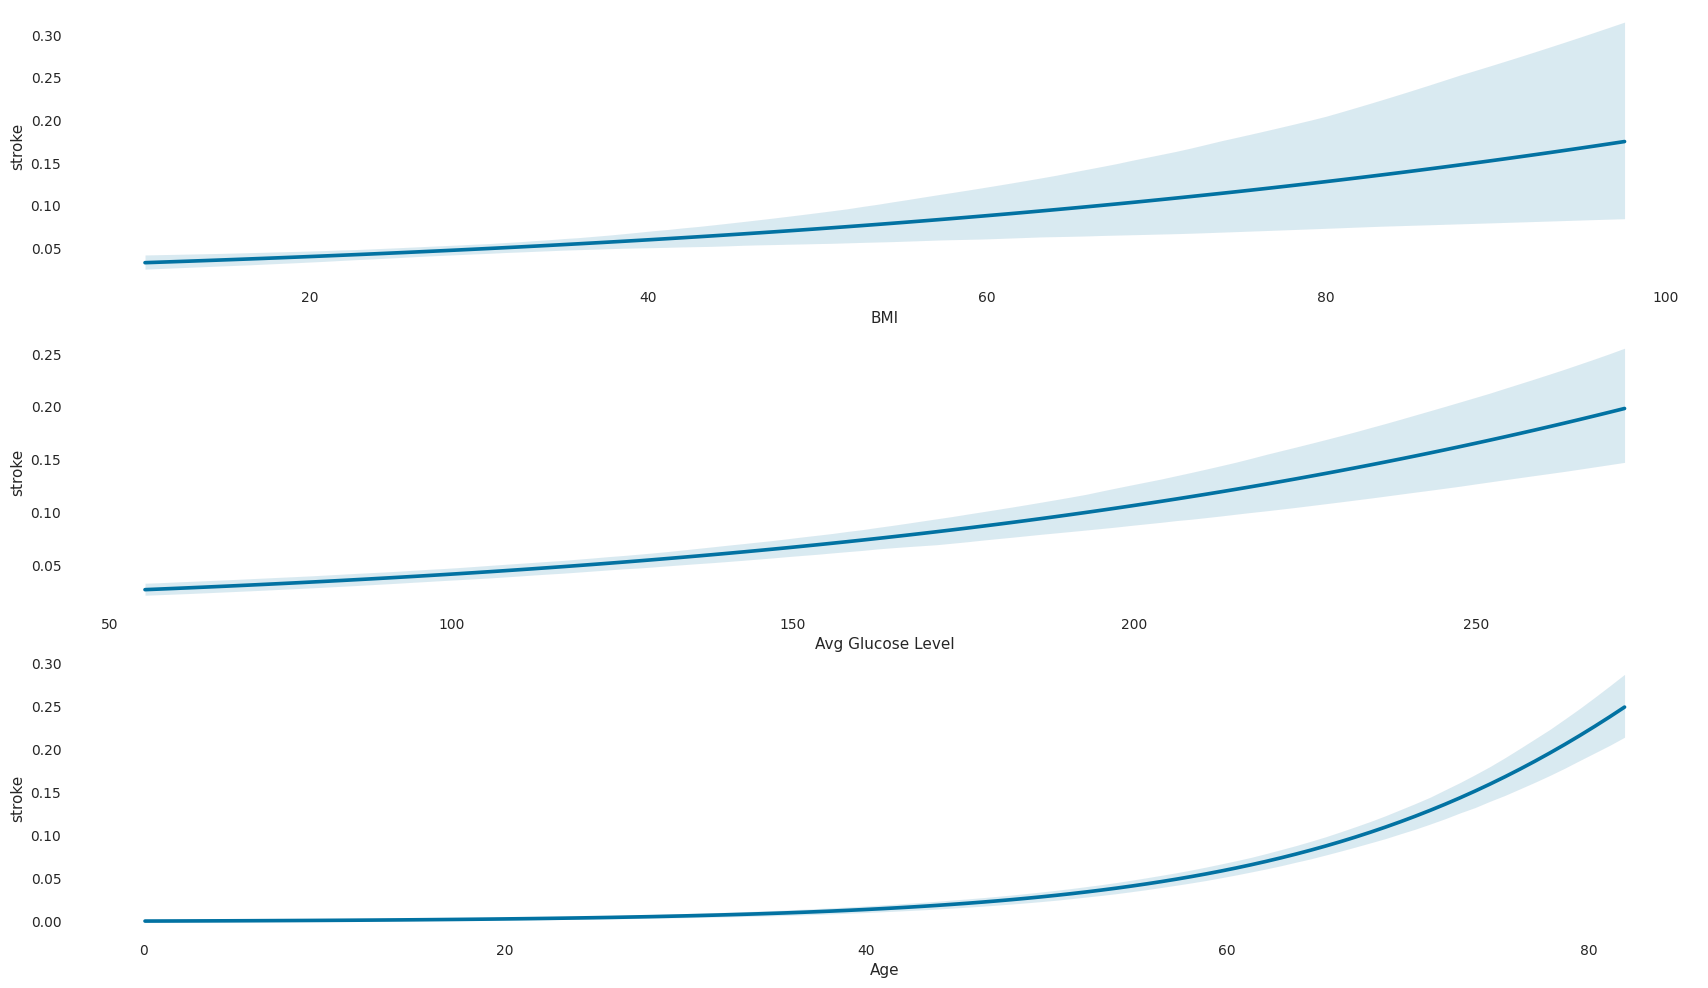

In [21]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(21,12));

plt.subplot(3,1,1)
sns.regplot(x=df['bmi'], y=df['stroke'], scatter=False, logistic=True, label= 'BMI');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.xlabel('BMI');

plt.subplot(3,1,2)
sns.regplot(x=df['avg_glucose_level'], y=df['stroke'], scatter=False, logistic=True, label='Avg Glucose Level');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.xlabel('Avg Glucose Level');

plt.subplot(3,1,3)
sns.regplot(x=df['age'], y=df['stroke'], scatter=False, logistic=True, label='Age');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.xlabel('Age');

In [22]:
# checking imbalances in class {1: stroke, 0:no stroke}
df['stroke'].value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

Preprocessing Data

In [23]:
# Encoding categorical values

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)
df['ever_married'] = df['ever_married'].replace({'Yes':1, 'No':0}).astype(np.uint8)
df['smoking_status'] = df['smoking_status'].replace({'never smoked':0,'Unknown':1,'formerly smoked':2,'smokes':-1}).astype(np.uint8)

Model Building

In [24]:
# Defining features and target

X = df.drop('stroke', axis=1)
y = df.pop('stroke')

In [25]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42, probability=True))])

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y)

In [27]:
# Our data is biased, we can fix this with SMOTE

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [28]:
from sklearn.model_selection import train_test_split,cross_val_score
svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
svm_cv.mean()

0.8421976771393537

Model Evaluation

In [29]:
from sklearn.metrics import confusion_matrix

svm_pipeline.fit(X_train_resh,y_train_resh);
svm_train_predict = svm_pipeline.predict(X_train)
svm_pred = svm_pipeline.predict(X_test)
svm_cm = confusion_matrix(y_train,svm_train_predict)
svm_cm

array([[2951,  689],
       [  74,  117]])

Auc :  0.7942905596382137


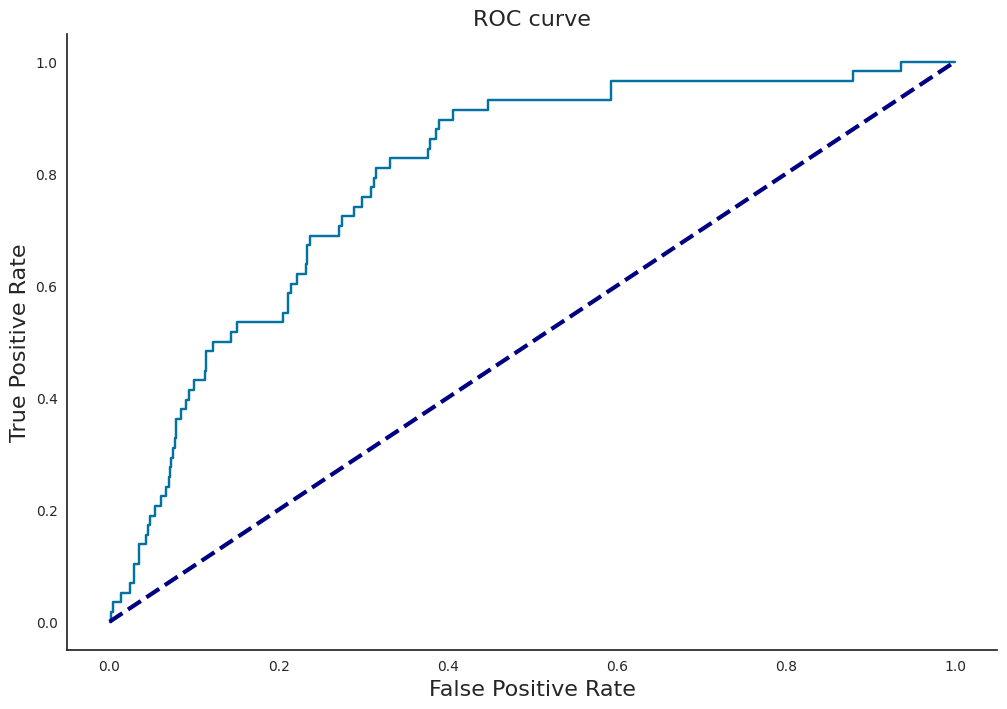

In [30]:
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, svm_pipeline.predict_proba(X_test)[:,1])

plt.figure(figsize=(12,8));

plt.plot(fpr_lr, tpr_lr);
plt.xlabel('False Positive Rate', fontsize=16);
plt.ylabel('True Positive Rate', fontsize=16);
plt.title('ROC curve', fontsize=16);
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--');
#plt.axes().set_aspect('equal');
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False);

print('Auc : ', auc(fpr_lr, tpr_lr))

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
print(classification_report(y_test, svm_pred))

print('Accuracy Score: ',accuracy_score(y_test,svm_pred))
print('F1 Score: ',f1_score(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1220
           1       0.11      0.53      0.19        58

    accuracy                           0.79      1278
   macro avg       0.54      0.67      0.53      1278
weighted avg       0.93      0.79      0.85      1278

Accuracy Score:  0.7918622848200313
F1 Score:  0.18902439024390244


In [33]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.0 MB/s eta 0:00:00


Prediction Explaination using SHAP

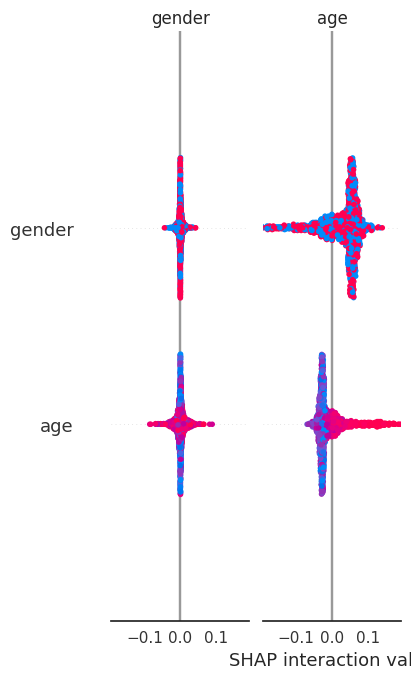

In [35]:
import shap
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(max_features=2, n_estimators=100, bootstrap=True)

# Fit the model to the training data
rfc.fit(X_train, y_train)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rfc)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_size=(19.5, 5), alpha=0.2)


# **Decision Tree**

# **Logistic Regression**